## From the article

# Implementing a distance-based classifier with a quantum interference circuit

###  M. Schuld et al 2017 EPL 119 60002

## Let's test the multiclass classifier with a simple data set

# Preparing the data

In [31]:
import numpy as np
from numpy import pi
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
data = pd.read_csv("clusters.csv", usecols=["f0", "f1", "class"])

In [33]:
# Create binary variables to filter data
isGreen = data["class"] == 'Green'
isBlue = data["class"] == 'Blue'
isBlack = data["class"] == 'Black'
isYellow = data["class"] == "Yellow"

In [34]:
# Filter data
greenData = data[isGreen]#.drop(['Class'], axis=1)
blueData = data[isBlue]#.drop(['Class'], axis=1)
blackData = data[isBlack]#.drop(['Class'], axis=1)
yellowData = data[isYellow]

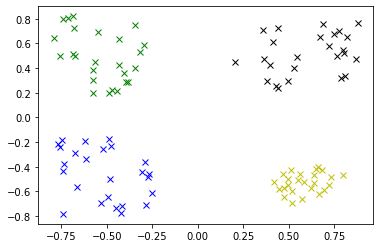

In [35]:
plt.plot(greenData["f0"], greenData["f1"], 'gx')
plt.plot(blueData["f0"], blueData["f1"], 'bx')
plt.plot(blackData["f0"], blackData["f1"], 'kx')
plt.plot(yellowData["f0"], yellowData["f1"], "yx")
# plt.savefig("Clusters/cluster.png", dpi=300)
plt.show()

In [36]:
# for feature in ["Feature 1", "Feature 2"]:
#     mean = data[feature].mean()
#     Min = data[feature].min()
#     Max = data[feature].max()
#     data[feature] = data[feature] - (Max + Min)/2
#     absMax = max(Max, -Min)
#     data[feature] /= absMax

In [37]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# data.loc[:,["Feature 1", "Feature 2"]] = scaler.fit_transform(data.loc[:,["Feature 1", "Feature 2"]])

In [38]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
       return v
    return v / norm

In [39]:
for i in data.index:
    v = [data["f0"][i],data["f1"][i]]
    v = normalize(v)
    data.loc[i,"f0"], data.loc[i,"f1"] = v[0], v[1]

In [41]:
# Filter data
greenData = data[isGreen]#.drop(['Class'], axis=1)
blueData = data[isBlue]#.drop(['Class'], axis=1)
blackData = data[isBlack]#.drop(['Class'], axis=1)
yellowData = data[isYellow]

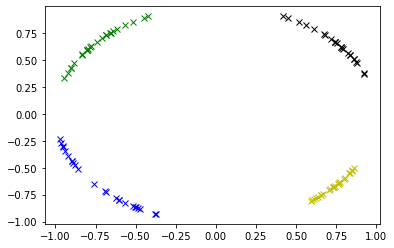

In [42]:
plt.plot(greenData["f0"], greenData["f1"], 'gx')
plt.plot(blueData["f0"], blueData["f1"], 'bx')
plt.plot(blackData["f0"], blackData["f1"], 'kx')
plt.plot(yellowData["f0"], yellowData["f1"], "yx")
# plt.savefig("Clusters/cluster.png", dpi=300)
plt.show()

In [10]:
# # Filter data
# greenData = data[isGreen]#.drop(['Class'], axis=1)
# blueData = data[isBlue]#.drop(['Class'], axis=1)
# blackData = data[isBlack]#.drop(['Class'], axis=1)

In [43]:
# random_seed : int : Random number generator seed
random_seed = 1
rgen = np.random.RandomState(random_seed)
def _shuffle(self, X, y):
    """Shuffle training data"""
    r = self.rgen.permutation(len(y))
    return X[r], y[r]

In [107]:
greenRandom = greenData.iloc[rgen.permutation(len(greenData.index))].copy()
blueRandom = blueData.iloc[rgen.permutation(len(blueData.index))].copy()
blackRandom = blackData.iloc[rgen.permutation(len(blackData.index))].copy()
yellowRandom = yellowData.iloc[rgen.permutation(len(yellowData.index))].copy()

greenRandom.loc[:, "f0":"f1"] = greenRandom.loc[:,"f0":"f1"].apply(np.arcsin)
blueRandom.loc[:, "f0":"f1"] = blueRandom.loc[:,"f0":"f1"].apply(np.arcsin)
blackRandom.loc[:, "f0":"f1"] = blackRandom.loc[:,"f0":"f1"].apply(np.arcsin)
yellowRandom.loc[:, "f0":"f1"] = yellowRandom.loc[:,"f0":"f1"].apply(np.arcsin)

greenTraining = greenRandom.iloc[:2]
blueTraining = blueRandom.iloc[:2]
blackTraining = blackRandom.iloc[:2]
yellowTraining = yellowRandom.iloc[:2]

greenInput = greenRandom.iloc[2]
blueInput = blueRandom.iloc[2]
blackInput = blackRandom.iloc[2]
yellowInput = yellowRandom.iloc[2]

trainingArray = pd.concat([greenTraining, blueTraining, blackTraining, yellowTraining])

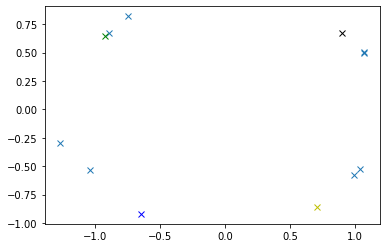

In [108]:
plt.plot(trainingArray["f0"], trainingArray["f1"], "x")
plt.plot(greenInput["f0"], greenInput["f1"], "gx")
plt.plot(blueInput["f0"], blueInput["f1"], "bx")
plt.plot(blackInput["f0"], blackInput["f1"], "kx")
plt.plot(yellowInput["f0"], yellowInput["f1"], "yx")
# plt.savefig("Clusters/random.png", dpi=300)
plt.show()

# Building the quantum circuit

In [22]:
import qiskit
from qiskit import IBMQ
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer)
from qiskit.visualization import plot_histogram

In [23]:
def encodeVector2(circuit, data, i, controls, rotationQubit, ancillaQubits):
    # |i> = |0>
    circuit.x(i)
    circuit.mcry(data[0], controls, rotationQubit, ancillaQubits)
    circuit.x(i)
    
    # |i> = |1>
    circuit.mcry(data[1], controls, rotationQubit, ancillaQubits)

def encodeClass(circuit, vectorClass):
    classSwitcher = {
        "Green": 0,
        "Blue": 1,
        "Black": 2,
        "Yellow": 3
    }
    
    # |c> = |00>
    if classSwitcher.get(vectorClass) == 0:
        circuit.x(c)
    # |c> = |01>
    elif classSwitcher.get(vectorClass) == 1:
        circuit.x(c[1])
    # |c> = |10>
    elif classSwitcher.get(vectorClass) == 2:
        circuit.x(c[0])
    # |c> = |11>
    elif classSwitcher.get(vectorClass) == 3:
        None

def encodeIndexBitwise3(circuit,index):
    """
    Encode the index of the training vectors with reason
    """
    
    zerosInIndex = index ^ 0b111
    
    if zerosInIndex & 0b001:
        circuit.x(m[0])
    if zerosInIndex & 0b010:
        circuit.x(m[1])
    if zerosInIndex & 0b100:
        circuit.x(m[2])

def encodeTraining(circuit, data, i, controls, rotationQubit, ancillaQubits, c, m):
    # Header
    encodeClass(circuit, c)
    encodeIndexBitwise3(circuit, m)
    
    # Encoder
    encodeVector2(circuit, data, i, controls, rotationQubit, ancillaQubits)
    
    # Footer
    encodeClass(circuit, c)
    encodeIndexBitwise3(circuit, m)

def buildTrainingState(trainingArray):
    """
    Given an array of up to 32 training vectors,
    build the quantum superposition state. 
    """
    for index in range(len(trainingArray.index)):
        trainingVector = trainingArray.iloc[index]
        encodeTraining(circuit, trainingVector["f0":"f1"], i, a[:]+i[:]+m[:]+c[:], r[0], q, trainingVector["class"], index)

In [145]:
a = QuantumRegister(1,'a') # knn ancilla
m = QuantumRegister(3,'m') # training vector index
i = QuantumRegister(1,'i') # feature index
r = QuantumRegister(1,'r') # rotation qubit
q = QuantumRegister(5,'q') # qram ancilla
c = QuantumRegister(2,'c') # class
b = ClassicalRegister(4, 'bit')
circuit = QuantumCircuit(a,m,i,r,q,c,b)

circuit.h(a)
circuit.h(m)
circuit.h(i)
circuit.h(c)

# >>> Encode the input vector >>>

encodeVector2(circuit, greenInput, i, a[:]+i[:], r[0], q)

circuit.x(a)

# <<< Encode the input vector <<<

# >>> Encode the training vectors >>>

buildTrainingState(trainingArray)

# <<< Encode the training vectors <<<

circuit.measure(r,b[0])

circuit.h(a)

circuit.measure(a,b[1])
circuit.measure(c[0],b[2])
circuit.measure(c[1],b[3])

circuit.draw(output='mpl')

ValueError: Image size of 1661x111935 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1661.52x111936 with 1 Axes>

In [135]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=8192)
result = job.result()
counts = result.get_counts(circuit)
print("\nTotal counts are:",counts)
# plot_histogram(counts)


Total counts are: {'1011': 105, '1110': 1, '1100': 1820, '1000': 1886, '1001': 112, '0000': 1816, '1101': 129, '0100': 1908, '0001': 56, '0010': 2, '0110': 1, '1010': 1, '0101': 86, '0011': 112, '1111': 63, '0111': 94}


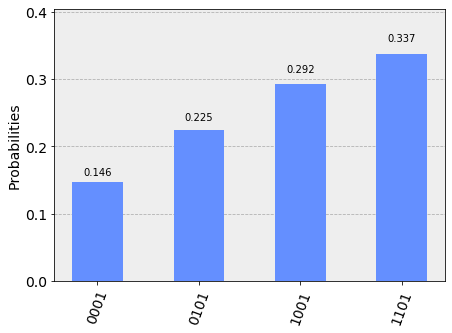

In [136]:
goodCounts = {k: counts[k] for k in counts.keys() & {'0001','0101','1001','1101'}}
plot_histogram(goodCounts)#.savefig("Clusters/yellow.png", dpi=300)

## Classificazione con vettori normalizzati
Classe verde: 9/9  
Classe blu: 8/9  
Classe nero: 9/9  
Classe giallo: 9/9

## Real hardware
See https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/fundamentals/3_the_ibmq_account.ipynb

In [138]:
provider = IBMQ.load_account()

In [139]:
print("Available backends:")
provider.backends()

Available backends:


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [140]:
from qiskit.providers.ibmq import least_busy

large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits >= 12 and not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())

The best backend is ibmq_16_melbourne


In [141]:
print(backend, backend.status().pending_jobs)

ibmq_16_melbourne 97


In [142]:
from qiskit.tools.monitor import job_monitor
# Number of shots to run the program (experiment);
# maximum is 8192 shots.
shots = 8192
# Maximum number of credits to spend on executions.
max_credits = 5

job_exp = execute(circuit, backend, shots=shots, max_credits=max_credits)

In [ ]:
job_monitor(job_exp)

In [144]:
job_exp.status()

<JobStatus.ERROR: 'job incurred error'>

In [246]:
job_exp.queue_position()

6

In [217]:
result_exp = job_exp.result()

JobError: 'Invalid job state. The job should be DONE but it is JobStatus.ERROR'

In [ ]:
counts_exp = result_exp.get_counts(circuit)

In [ ]:
goodCounts_exp = {k: counts_exp[k] for k in counts_exp.keys() & {'0001', '0101', '1001', '1101'}}

In [ ]:
plot_histogram(goodCounts_exp)#.savefig(images/setosa_reale_20190913:1716.png', dpi=300)